In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 20

# Frozen layers

We will use the more challenging food101 dataset again.

The idea behind frezing layers is that not every layer needs to be fine tuned towards the new data. 
The lower layers of a neural network are used for very basic shapes where to higher layers are used for more specific features.
So by keeping the basic features we can train less parameters.

This will have 2 benefits.

Less data needed: The amount of data you need to train a network depence on the amount of parameters you need to train.

Less time: Training less parameters will cost less time.

In general the trade off is: The more of the model is frozen the less data/time is needed BUT to lower the maximum performence


In [2]:
from get_dataset import DataSetGenerator
dataset_generator = DataSetGenerator(
    data_location=r"D:\data\food",
    batch_size=64,
    patch_dimension=128)
train_ds, val_ds = dataset_generator.get_datasets()

## Let's have a look at the data we are dealing with

We will vizualize 64 random images and there labels just to see what we are dealing with.
These image already have some data augmentation.

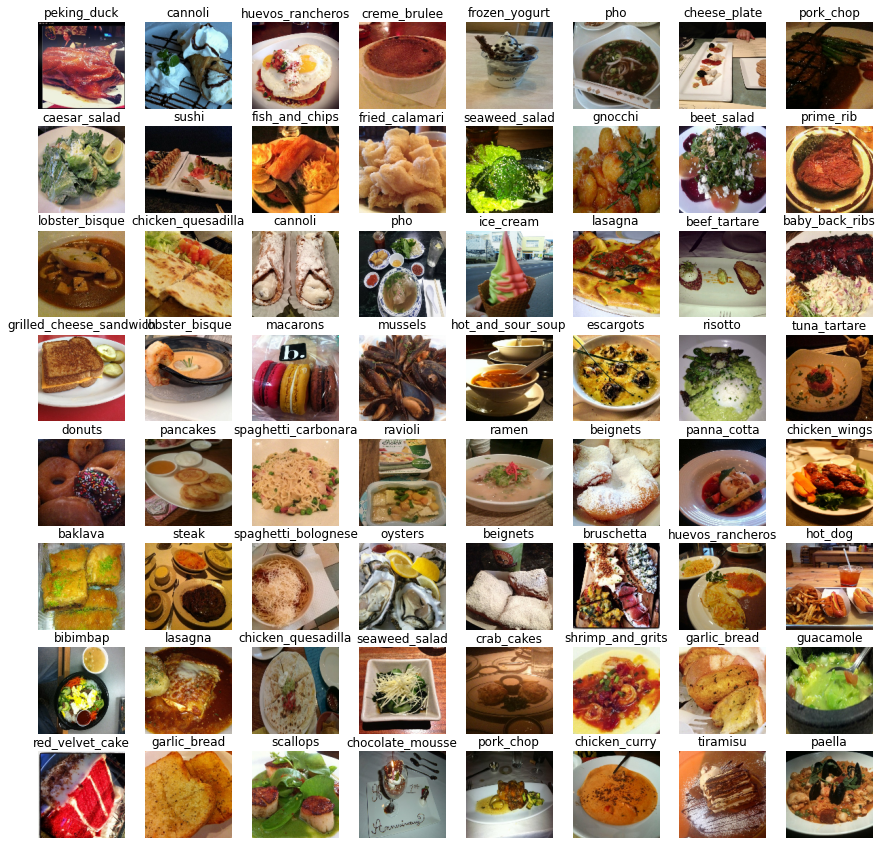

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
  for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset_generator.class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have pre-trained weights VS random weights.

The model that is loaded is without a head because we only have 101 classes not thousands.

Also we add the option to freeze layers. That way their weights are not updated during training.

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(num_frozen_blocks: int = 0):
    n_classes = len(dataset_generator.class_names)
    pre_trained_model = EfficientNetB0(include_top=False, weights="imagenet")

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    all_layers = ["stem", "block1", "block2", "block3", "block4", "block5", "block6","block7", "top"]
    layers2freeze = tuple(all_layers[:num_frozen_blocks])
    for layer in model.layers:
        if layer.name.startswith(layers2freeze):
            layer.trainable = False

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model


## 4 frozen layers
We freeze the first 4 layers. There are not a lot of parameters in the first layers. But these are all very basic features. Meaning the chance these layers needs to be retrained is lower.

model_frozen_base.summary() gives us:
- Total params: 4,178,952
- Trainable params: 4,071,199
- Non-trainable params: 107,753

In [5]:
model_frozen_base = create_model(4)
history = model_frozen_base.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 699s 633ms/step - loss: 2.2063 - accuracy: 0.4683 - val_loss: 1.6877 - val_accuracy: 0.5704
Epoch 2/20
1105/1105 [==============================] - 153s 138ms/step - loss: 1.3708 - accuracy: 0.6380 - val_loss: 1.5988 - val_accuracy: 0.6014
Epoch 3/20
1105/1105 [==============================] - 152s 138ms/step - loss: 1.0878 - accuracy: 0.7030 - val_loss: 1.5516 - val_accuracy: 0.6194
Epoch 4/20
1105/1105 [==============================] - 152s 138ms/step - loss: 0.8944 - accuracy: 0.7483 - val_loss: 1.6408 - val_accuracy: 0.6229
Epoch 5/20
1105/1105 [==============================] - 146s 132ms/step - loss: 0.7456 - accuracy: 0.7853 - val_loss: 1.6370 - val_accuracy: 0.6228
Epoch 6/20
1105/1105 [==============================] - 146s 132ms/step - loss: 0.6258 - accuracy: 0.8150 - val_loss: 1.7954 - val_accuracy: 0.6172
Epoch 7/20
1105/1105 [==============================] - 145s 131ms/step - loss: 0.5307 - accuracy: 0.8409 - val_

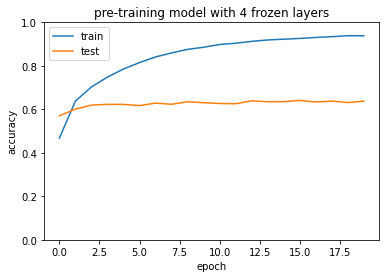

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 4 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

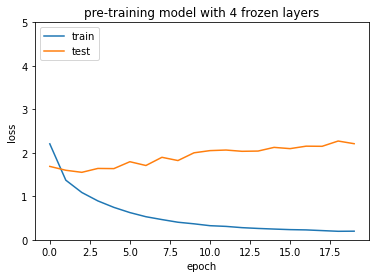

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 4 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 8 frozen layers
We freeze the first 8 layers. This are most of the layers but still less then half the parameters.

model_very_frozen.summary() gives us:
- Total params: 4,178,952
- Trainable params: 541,541
- Non-trainable params: 3,637,411

In [8]:
model_very_frozen = create_model(8)
history = model_very_frozen.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 114s 104ms/step - loss: 2.5908 - accuracy: 0.4261 - val_loss: 2.0713 - val_accuracy: 0.5060
Epoch 2/20
1105/1105 [==============================] - 111s 101ms/step - loss: 1.6889 - accuracy: 0.5710 - val_loss: 2.0094 - val_accuracy: 0.5250
Epoch 3/20
1105/1105 [==============================] - 106s 96ms/step - loss: 1.4265 - accuracy: 0.6251 - val_loss: 1.9503 - val_accuracy: 0.5376
Epoch 4/20
1105/1105 [==============================] - 112s 101ms/step - loss: 1.2358 - accuracy: 0.6686 - val_loss: 2.0137 - val_accuracy: 0.5391
Epoch 5/20
1105/1105 [==============================] - 112s 102ms/step - loss: 1.0693 - accuracy: 0.7049 - val_loss: 2.0500 - val_accuracy: 0.5439
Epoch 6/20
1105/1105 [==============================] - 110s 99ms/step - loss: 0.9399 - accuracy: 0.7352 - val_loss: 2.1066 - val_accuracy: 0.5404
Epoch 7/20
1105/1105 [==============================] - 112s 101ms/step - loss: 0.8179 - accuracy: 0.7645 - val_lo

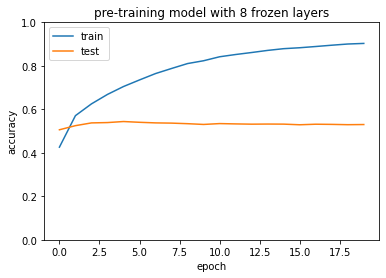

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 8 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

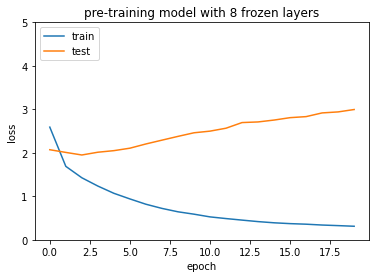

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 8 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model completely frozen
In here we freeze the whole base model and only train the head. This is the most extreem you can go with frozen models.

If you type model_completely_frozen.summary() you will see:
- Total params: 4,178,952
- Trainable params: 129,381
- Non-trainable params: 4,049,571

In [11]:
model_completely_frozen = create_model(9)
history = model_completely_frozen.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 111s 101ms/step - loss: 2.7531 - accuracy: 0.3927 - val_loss: 2.3466 - val_accuracy: 0.4690
Epoch 2/20
1105/1105 [==============================] - 116s 105ms/step - loss: 2.0392 - accuracy: 0.5134 - val_loss: 2.2535 - val_accuracy: 0.4909
Epoch 3/20
1105/1105 [==============================] - 109s 99ms/step - loss: 1.8372 - accuracy: 0.5521 - val_loss: 2.2404 - val_accuracy: 0.5034
Epoch 4/20
1105/1105 [==============================] - 110s 99ms/step - loss: 1.7120 - accuracy: 0.5761 - val_loss: 2.2881 - val_accuracy: 0.5010
Epoch 5/20
1105/1105 [==============================] - 115s 105ms/step - loss: 1.6389 - accuracy: 0.5897 - val_loss: 2.3139 - val_accuracy: 0.5037
Epoch 6/20
1105/1105 [==============================] - 115s 104ms/step - loss: 1.5779 - accuracy: 0.6001 - val_loss: 2.4103 - val_accuracy: 0.4970
Epoch 7/20
1105/1105 [==============================] - 130s 118ms/step - loss: 1.5401 - accuracy: 0.6086 - val_lo

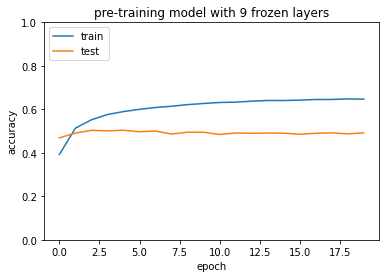

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 9 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

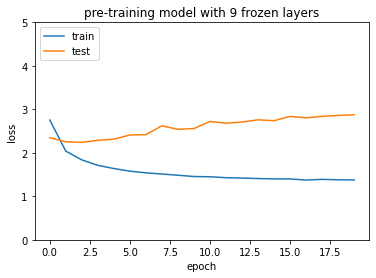

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 9 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Conclusion

In this example we can see a small improvement in time.
But once again there is more speed to win by looking into technical optimalizations.

The model got the same amount of data each time and we can see there is enough data for a full training.